## Introduction


This is a Kaggle project to predict best fertilizers based on weather, soil types and crops. Previously, Random Forest was used to build the model, but model performance is poor. So using XGBoost to see if that improves performance.

## Step-1:  Import Libraries

In [12]:
# Import

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split,RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from xgboost import XGBClassifier

from scipy.stats import uniform, randint

# Step-2: Load Dataset

In [3]:
train_set= pd.read_csv('Data/train.csv')
train_set=train_set.rename(columns={'Fertilizer Name':'Fertilizer_Name'})


# Step-3: Exploratory Data Analysis (EDA)

# 3.1 Data Overview

In [4]:
train_set

,id,Temparature,Humidity,Moisture,Soil Type,Crop Type,Nitrogen,Potassium,Phosphorous,Fertilizer_Name
0,0,37,70,36,Clayey,Sugarcane,36,4,5,28-28
1,1,27,69,65,Sandy,Millets,30,6,18,28-28
2,2,29,63,32,Sandy,Millets,24,12,16,17-17-17
3,3,35,62,54,Sandy,Barley,39,12,4,10-26-26
4,4,35,58,43,Red,Paddy,37,2,16,DAP
...,...,...,...,...,...,...,...,...,...,...
749995,749995,25,69,30,Clayey,Maize,8,16,6,28-28
749996,749996,37,64,58,Loamy,Sugarcane,38,8,20,17-17-17
749997,749997,35,68,59,Sandy,Ground Nuts,6,11,29,10-26-26
749998,749998,31,68,29,Red,Cotton,9,11,12,20-20


In [4]:
train_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 750000 entries, 0 to 749999
Data columns (total 10 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   id               750000 non-null  int64 
 1   Temparature      750000 non-null  int64 
 2   Humidity         750000 non-null  int64 
 3   Moisture         750000 non-null  int64 
 4   Soil Type        750000 non-null  object
 5   Crop Type        750000 non-null  object
 6   Nitrogen         750000 non-null  int64 
 7   Potassium        750000 non-null  int64 
 8   Phosphorous      750000 non-null  int64 
 9   Fertilizer_Name  750000 non-null  object
dtypes: int64(7), object(3)
memory usage: 57.2+ MB


In [5]:
train_set.describe()

,id,Temparature,Humidity,Moisture,Nitrogen,Potassium,Phosphorous
count,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000
mean,374999.500000,31.503565,61.038912,45.184147,23.093808,9.478296,21.073227
std,216506.495284,4.025574,6.647695,11.794594,11.216125,5.765622,12.346831
min,0.000000,25.000000,50.000000,25.000000,4.000000,0.000000,0.000000
25%,187499.750000,28.000000,55.000000,35.000000,13.000000,4.000000,10.000000
50%,374999.500000,32.000000,61.000000,45.000000,23.000000,9.000000,21.000000
75%,562499.250000,35.000000,67.000000,55.000000,33.000000,14.000000,32.000000
max,749999.000000,38.000000,72.000000,65.000000,42.000000,19.000000,42.000000


In [6]:
# How many unique Fertilizers in the data?
train_set.Fertilizer_Name.unique()

array(['28-28', '17-17-17', '10-26-26', 'DAP', '20-20', '14-35-14',
       'Urea'], dtype=object)

# 3.2: Check for missing values

In [7]:
train_set.isnull().sum()

id                 0
Temparature        0
Humidity           0
Moisture           0
Soil Type          0
Crop Type          0
Nitrogen           0
Potassium          0
Phosphorous        0
Fertilizer_Name    0
dtype: int64

# 3.3: Visualizations

array([[<AxesSubplot:title={'center':'Temparature'}>,
        <AxesSubplot:title={'center':'Humidity'}>],
       [<AxesSubplot:title={'center':'Moisture'}>,
        <AxesSubplot:title={'center':'Nitrogen'}>],
       [<AxesSubplot:title={'center':'Potassium'}>,
        <AxesSubplot:title={'center':'Phosphorous'}>]], dtype=object)

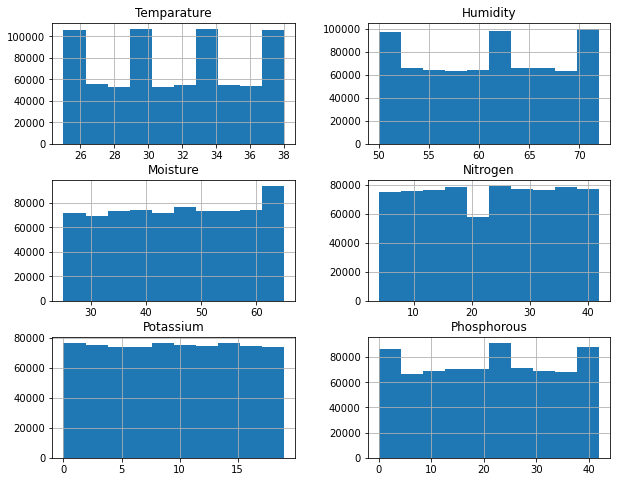

In [8]:
# Distribution of numerical features
train_set[['Temparature', 'Humidity', 'Moisture', 'Nitrogen', 'Potassium', 'Phosphorous']].hist(figsize=(10,8))



(array([0, 1, 2, 3, 4, 5, 6]),
 [Text(0, 0, '28-28'),
  Text(1, 0, '17-17-17'),
  Text(2, 0, '10-26-26'),
  Text(3, 0, 'DAP'),
  Text(4, 0, '20-20'),
  Text(5, 0, '14-35-14'),
  Text(6, 0, 'Urea')])

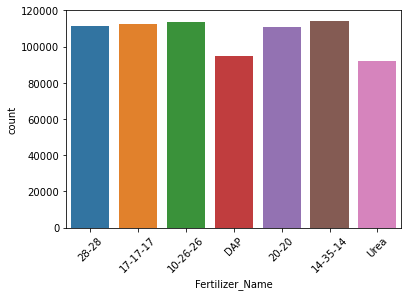

In [9]:
# Fertilizer distribution
sns.countplot(x='Fertilizer_Name', data=train_set)
plt.xticks(rotation=45)




In [10]:
# Pairplot (optional)
#sns.pairplot(train_set, hue='Fertilizer_Name')

In [11]:
# What are the correlations between different features?
train_set.corr()

,id,Temparature,Humidity,Moisture,Nitrogen,Potassium,Phosphorous
id,1.000000,-0.001069,-0.000310,0.001752,0.001505,-0.000375,-0.001234
Temparature,-0.001069,1.000000,0.001758,-0.001633,-0.006073,-0.009913,0.000298
Humidity,-0.000310,0.001758,1.000000,0.003424,0.006502,0.005229,0.002413
Moisture,0.001752,-0.001633,0.003424,1.000000,0.003016,-0.001931,-0.006735
Nitrogen,0.001505,-0.006073,0.006502,0.003016,1.000000,0.000543,-0.005464
Potassium,-0.000375,-0.009913,0.005229,-0.001931,0.000543,1.000000,0.000113
Phosphorous,-0.001234,0.000298,0.002413,-0.006735,-0.005464,0.000113,1.000000


# 3.4: Categorical Analysis

In [12]:
print(train_set['Soil Type'].value_counts())
print(train_set['Crop Type'].value_counts())


Sandy     156710
Black     150956
Clayey    148382
Red       148102
Loamy     145850
Name: Soil Type, dtype: int64
Paddy          85754
Pulses         78180
Cotton         69171
Tobacco        68000
Wheat          66628
Millets        65291
Barley         65045
Sugarcane      64269
Oil seeds      64184
Maize          62569
Ground Nuts    60909
Name: Crop Type, dtype: int64


# Step-4: Feature Engineering and Encoding

# 4.1: Drop Unnecessary Columns


In [5]:
train_set.drop(columns=['id'], inplace=True)

# 4.2: Encoding Categorical Variables

In [6]:
label_encoders={}

for col in ['Soil Type', 'Crop Type', 'Fertilizer_Name']:
    le=LabelEncoder()
    train_set[col]= le.fit_transform(train_set[col])
    label_encoders[col]=le

In [15]:
# Check data after encoding (Optional)
#train_set

# 4.3: Feature/Target Split

In [7]:
X = train_set.drop(columns=['Fertilizer_Name'])
y = train_set['Fertilizer_Name']


In [8]:
print(X.shape)
print(y.shape)

(750000, 8)
(750000,)


# Setp-5: Feature Scaling

In [8]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


In [11]:
print(X_scaled.shape)
print(y.shape)

(750000, 8)
(750000,)


# Step-6: Model Selection & Training

In [13]:
# Train-Test split
X_train, X_test,y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Define base XGBoost model
xgb = XGBClassifier(
    use_label_encoder=False,
    eval_metric='mlogloss',
    random_state=42
)

# 7. Define parameter distribution
param_dist = {
    'n_estimators': randint(50, 300),
    'max_depth': randint(3, 10),
    'learning_rate': uniform(0.01, 0.2),
    'subsample': uniform(0.7, 0.3),
    'colsample_bytree': uniform(0.7, 0.3)
}

# 8. Randomized Search
random_search = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_dist,
    n_iter=30,              # Number of random combinations to try
    scoring='accuracy',
    cv=3,
    verbose=1,
    n_jobs=-1,
    random_state=42
)

# 9. Fit the model
random_search.fit(X_train, y_train)

Fitting 3 folds for each of 30 candidates, totalling 90 fits


/Users/merina/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [22:32:41] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


RandomizedSearchCV(cv=3,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric='mlogloss',
                                           feature_types=None, gamma=None,
                                           grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learnin...
                                        'learning_rate': <scipy.stats._distn_infrastructure.rv_

# Step-7: Model Evaluation

In [14]:
print("Best Parameters:", random_search.best_params_)

best_model = random_search.best_estimator_
y_pred = best_model.predict(X_test)

print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("Test Accuracy:", accuracy_score(y_test, y_pred))

Best Parameters: {'colsample_bytree': 0.7039794883479599, 'learning_rate': 0.19844035113697056, 'max_depth': 8, 'n_estimators': 291, 'subsample': 0.8156249507619748}

Classification Report:
               precision    recall  f1-score   support

           0       0.21      0.23      0.22     22841
           1       0.20      0.25      0.22     22639
           2       0.21      0.24      0.22     22764
           3       0.19      0.20      0.20     22010
           4       0.19      0.20      0.20     22384
           5       0.21      0.16      0.18     19148
           6       0.19      0.12      0.15     18214

    accuracy                           0.20    150000
   macro avg       0.20      0.20      0.20    150000
weighted avg       0.20      0.20      0.20    150000

Test Accuracy: 0.20157333333333333


The model performance is also poor. So we need to refine the model or choose a different model to improve performace. Will try Staritified K-fold later.

# Step-8: Feature Importance

Text(0.5, 1.0, 'Feature Importances')

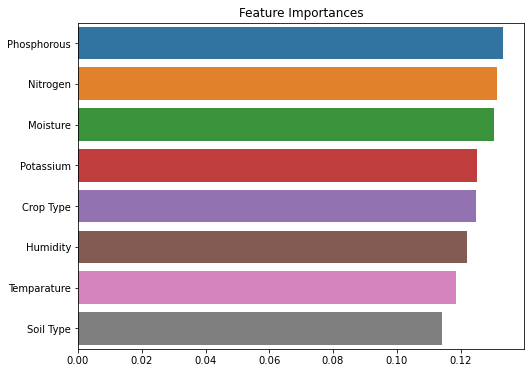

In [15]:
importances = best_model.feature_importances_
features = X.columns
sorted_idx = np.argsort(importances)[::-1]

plt.figure(figsize=(8,6))
sns.barplot(x=importances[sorted_idx], y=features[sorted_idx])
plt.title('Feature Importances')


# Step-9: Predict on New/Test Data:

In [30]:
# Load test data

test_input=pd.read_csv('Data/test.csv')

# Preserve Original data to save id

result_df=test_input.copy()


In [31]:
# Drop id column
test_input.drop(columns=['id'], inplace=True)

In [32]:
test_input.isnull().sum()

Temparature    0
Humidity       0
Moisture       0
Soil Type      0
Crop Type      0
Nitrogen       0
Potassium      0
Phosphorous    0
dtype: int64

array([[<AxesSubplot:title={'center':'Temparature'}>,
        <AxesSubplot:title={'center':'Humidity'}>],
       [<AxesSubplot:title={'center':'Moisture'}>,
        <AxesSubplot:title={'center':'Nitrogen'}>],
       [<AxesSubplot:title={'center':'Potassium'}>,
        <AxesSubplot:title={'center':'Phosphorous'}>]], dtype=object)

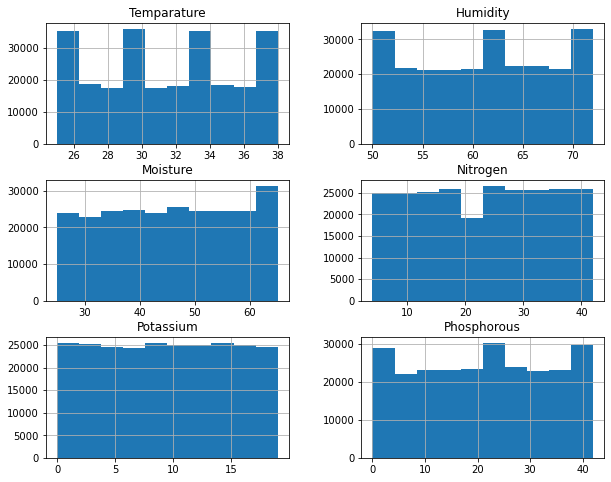

In [33]:
# Distribution of numerical features
test_input[['Temparature', 'Humidity', 'Moisture', 'Nitrogen', 'Potassium', 'Phosphorous']].hist(figsize=(10,8))



In [34]:
test_input.dtypes

Temparature     int64
Humidity        int64
Moisture        int64
Soil Type      object
Crop Type      object
Nitrogen        int64
Potassium       int64
Phosphorous     int64
dtype: object

In [36]:
# Encode categorical features
for col in ['Soil Type', 'Crop Type']:
    test_input[col] = label_encoders[col].transform(test_input[col])
# Scale features
test_input_scaled = scaler.transform(test_input)

# Predict
pred_fert = model.predict(test_input_scaled)
fertilizer_names = label_encoders['Fertilizer_Name'].inverse_transform(pred_fert)
test_input['Predicted_Fertilizer'] = fertilizer_names
print(test_input)

        Temparature  Humidity  Moisture  Soil Type  Crop Type  Nitrogen  \
0                31        70        52          4         10        34   
1                27        62        45          3          8        30   
2                28        72        28          1          2        14   
3                37        53        57          0          2        18   
4                31        55        32          3          7        13   
...             ...       ...       ...        ...        ...       ...   
249995           26        66        30          3          8        14   
249996           33        62        55          3          7        28   
249997           36        53        64          0          6        28   
249998           36        67        26          1          6        33   
249999           35        63        36          1          2        29   

        Potassium  Phosphorous Predicted_Fertilizer  
0              11           24               

In [37]:
# Predict top 3 fertilizers

probs = model.predict_proba(test_input_scaled)  # shape: (n_samples, n_classes)


In [38]:
# Get top 3 class indices for each samples
top3_indices = np.argsort(probs, axis=1)[:, -3:][:, ::-1]  # shape: (n_samples, 3)


In [39]:
# Convert indices into fertilizer names
top3_ferts = np.array(label_encoders['Fertilizer_Name'].inverse_transform(
    np.ravel(top3_indices)
)).reshape(top3_indices.shape)


In [40]:
# Add to test dataframe
result_df['Top1'] = top3_ferts[:, 0]
result_df['Top2'] = top3_ferts[:, 1]
result_df['Top3'] = top3_ferts[:, 2]

print(result_df[['id','Top1', 'Top2', 'Top3']])


            id      Top1      Top2      Top3
0       750000       DAP      Urea     28-28
1       750001  17-17-17       DAP     28-28
2       750002     20-20      Urea  10-26-26
3       750003      Urea  17-17-17       DAP
4       750004     20-20  17-17-17     28-28
...        ...       ...       ...       ...
249995  999995      Urea  10-26-26     20-20
249996  999996  10-26-26  14-35-14      Urea
249997  999997  14-35-14  10-26-26     20-20
249998  999998       DAP     28-28      Urea
249999  999999  14-35-14  17-17-17     20-20

[250000 rows x 4 columns]


In [42]:
submission_set=result_df[['id','Top1','Top2', 'Top3']]

In [43]:
submission_set


,id,Top1,Top2,Top3
0,750000,DAP,Urea,28-28
1,750001,17-17-17,DAP,28-28
2,750002,20-20,Urea,10-26-26
3,750003,Urea,17-17-17,DAP
4,750004,20-20,17-17-17,28-28
...,...,...,...,...
249995,999995,Urea,10-26-26,20-20
249996,999996,10-26-26,14-35-14,Urea
249997,999997,14-35-14,10-26-26,20-20
249998,999998,DAP,28-28,Urea


In [50]:
result_df['Top3_Predictions'] = result_df[['Top1', 'Top2', 'Top3']].agg(' '.join, axis=1)

# Set 'id' as index
result_df.set_index('id', inplace=True)

# Optional: display result
print(result_df)


        Temparature  Humidity  Moisture Soil Type    Crop Type  Nitrogen  \
id                                                                         
750000           31        70        52     Sandy        Wheat        34   
750001           27        62        45       Red    Sugarcane        30   
750002           28        72        28    Clayey  Ground Nuts        14   
750003           37        53        57     Black  Ground Nuts        18   
750004           31        55        32       Red       Pulses        13   
...             ...       ...       ...       ...          ...       ...   
999995           26        66        30       Red    Sugarcane        14   
999996           33        62        55       Red       Pulses        28   
999997           36        53        64     Black        Paddy        28   
999998           36        67        26    Clayey        Paddy        33   
999999           35        63        36    Clayey  Ground Nuts        29   

        Pot

In [52]:
submission_df=result_df[['Top3_Predictions']]

In [53]:
submission_df

,Top3_Predictions
id,
750000,DAP Urea 28-28
750001,17-17-17 DAP 28-28
750002,20-20 Urea 10-26-26
750003,Urea 17-17-17 DAP
750004,20-20 17-17-17 28-28
...,...
999995,Urea 10-26-26 20-20
999996,10-26-26 14-35-14 Urea
999997,14-35-14 10-26-26 20-20


In [54]:
submission_df.to_csv('fertilizer_prediction_submission.csv')